In [1]:
%%capture
!pip uninstall jax jaxlib -y
!pip install --upgrade "jax[cuda11_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
#!pip install jax[tpu] -f https://storage.googleapis.com/jax-releases/libtpu_releases.html
!pip install --upgrade einops optax equinox jax-tqdm tqdm


In [2]:
import jax
jax.devices()

[gpu(id=0)]

In [3]:
from jax import random, value_and_grad, lax, vmap
from optax import adam, sgd, apply_updates, chain, clip, softmax_cross_entropy_with_integer_labels
from einops import rearrange, reduce, repeat
from functools import partial
from tqdm.notebook import tqdm
import equinox as eqx
import tensorflow_datasets as tfds
import tensorflow as tf
from jax.random import split, normal, randint
from jax.nn import relu, gelu, sigmoid, softmax
from jax import disable_jit
from jax.tree_util import tree_map, tree_leaves
import jax
from jax_tqdm import scan_tqdm
from jax import lax
import jax.numpy as jnp

import copy
import matplotlib.pyplot as plt

# Typing
from jax import Array
from typing import Optional, Sequence, Tuple, Any
from jax.random import PRNGKeyArray

SEED = 0
MODEL_KEY = random.PRNGKey(SEED)
TEST_KEY = random.PRNGKey(SEED + 1)
TRAIN_KEY = random.PRNGKey(SEED + 2)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [4]:
N_CHARACTERS = 20

def extraction(image, label):
    # This function will shrink the Omniglot images to the desired size,
    # scale pixel values and convert the RGB image to grayscale
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.resize(image, [28, 28])
    image = 1 - image
    return image, label


with jax.default_device(jax.devices("cpu")[0]):
    data = tfds.load("omniglot", split=["train+test"], data_dir="data", as_supervised=True, shuffle_files=False)[0]
    data = data.map(extraction)
    data_img, data_labels = [jnp.array(i) for i in list(zip(*data.as_numpy_iterator()))]
    data_img = rearrange(data_img, "b h w c -> b c h w")


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/4 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/19280 [00:00<?, ? examples/s]

Shuffling data/omniglot/3.0.0.incomplete0LEQRR/omniglot-train.tfrecord*...:   0%|          | 0/19280 [00:00<?,…

Generating test examples...:   0%|          | 0/13180 [00:00<?, ? examples/s]

Shuffling data/omniglot/3.0.0.incomplete0LEQRR/omniglot-test.tfrecord*...:   0%|          | 0/13180 [00:00<?, …

Generating small1 examples...:   0%|          | 0/2720 [00:00<?, ? examples/s]

Shuffling data/omniglot/3.0.0.incomplete0LEQRR/omniglot-small1.tfrecord*...:   0%|          | 0/2720 [00:00<?,…

Generating small2 examples...:   0%|          | 0/3120 [00:00<?, ? examples/s]

Shuffling data/omniglot/3.0.0.incomplete0LEQRR/omniglot-small2.tfrecord*...:   0%|          | 0/3120 [00:00<?,…

Dataset omniglot downloaded and prepared to data/omniglot/3.0.0. Subsequent calls will reuse this data.


In [5]:
# sort the data set
with jax.default_device(jax.devices("cpu")[0]):

    indices_sorted_labels = sorted(range(len(data_labels)), key=lambda k: data_labels[k])
    sorted_data_labels = data_labels[jnp.array(indices_sorted_labels)]
    sorted_data_img = data_img[jnp.array(indices_sorted_labels)]

sorted_data_img_split = rearrange(sorted_data_img, "(l i) c h w -> l i c h w", i=20)

In [6]:
# Randomly select 1200 characters to meta train on.
# Meta test on the rest.
n_meta_train = 1200

perm = random.permutation(MODEL_KEY, 1623)
scrambled_data_img_split = sorted_data_img_split[perm]

meta_train, meta_train_labels = scrambled_data_img_split[:n_meta_train], perm[:n_meta_train]
meta_test, meta_test_labels = scrambled_data_img_split[n_meta_train:], perm[n_meta_train:]

1487


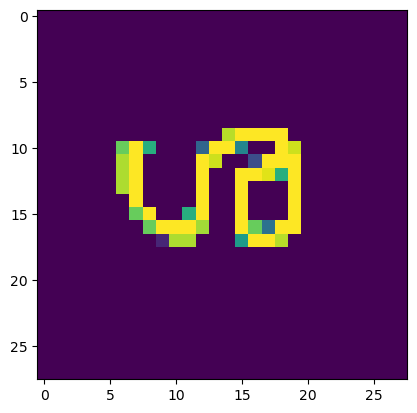

In [7]:
test_img = meta_train[469][15]
print(meta_train_labels[1103])
plt.imshow(test_img[0])
plt.show()

In [8]:
def multi_batch_loss(model, batch_loss, batch_of_tasks, inner_step, inner_optim, inner_opt_state, state) -> Array:
    """Compute the loss over all models"""

    # get model_i', test_i, test_labels_i for all tasks i: #
    old_state = state
    train_tasks, test_tasks = batch_of_tasks
    # vmap over tasks inner step
    models, state = eqx.filter_vmap(inner_step,in_axes=(None,0,None,None,None,None),
                             out_axes=(eqx.if_array(0),None),axis_name="tasks"
                                   )(model, train_tasks, batch_loss,inner_optim, inner_opt_state, state)
    # sum loss_i(model_i', test_i, test_labels_i)
    loss, state = eqx.filter_vmap(batch_loss,
                                  in_axes=(eqx.if_array(0),0,None),
                                  out_axes=(0, None),axis_name="tasks"
                                 )(models, test_tasks, state)
    return loss.mean(), state # old_state

In [9]:
def batch_loss(model, task, state) -> Array:
    '''Compute the loss.'''

    def loss(image: Array, label: Array, state):
        pred, state = model(image, state)

        return  softmax_cross_entropy_with_integer_labels(pred,label), state

    # Unpack task
    images, labels = task
    # Mean over the batch
    l, state = eqx.filter_vmap(loss, axis_name="chars", in_axes=(0, 0, None), out_axes=(0, None))(images, labels, state)

    return l.mean(), state

In [10]:
@partial(eqx.filter_jit)
def outer_step_REPTILE(model, batch_loss, outer_optim, outer_opt_state,
         inner_step, batch_of_tasks, inner_optim, inner_opt_state, state, epsilon):

    train_tasks, test_tasks = batch_of_tasks

    models, state, losses = eqx.filter_vmap(inner_step,in_axes=(None,0,None,None,None,None),
                             out_axes=(eqx.if_array(0),None, 0),axis_name="tasks"
                                   )(model, train_tasks, batch_loss,inner_optim, inner_opt_state, state)

    model_tilde = tree_map(lambda x: x.mean(0), eqx.filter(models,eqx.is_array))

    dyn_model = tree_map((lambda x,y: x+epsilon*(y-x)), eqx.filter(model,eqx.is_array), eqx.filter(model_tilde,eqx.is_array))
    model = eqx.combine(dyn_model, model)

    loss, outer_opt_state = None, None
    return losses.mean(), model, outer_opt_state, state

In [11]:
def step(batch_loss, model, train_task, opt_state, optim, state):
    (loss,state), grad = eqx.filter_value_and_grad(batch_loss, has_aux=True)(model, train_task, state)  # Compute loss and gradient
    updates, opt_state = optim.update(grad, opt_state, model)  # Theta = Theta - alpha*grad(loss)
    model = eqx.apply_updates(model, updates)  # Model = Model(Theta_new)
    return model, opt_state, state, loss

In [12]:
def inner_step_REPTILE(model, train_tasks, batch_loss, inner_optim, inner_opt_state, state, n_steps=5):

    dynamic_model, static_model = eqx.partition(model, eqx.is_array)
    
    def scan_step(carry, i):
        dynamic_model, inner_opt_state, state = carry
        model, inner_opt_state, state, loss = step(batch_loss, eqx.combine(dynamic_model,static_model), 
                                             train_tasks, inner_opt_state, inner_optim, state)
        return (eqx.filter(model, eqx.is_array), inner_opt_state, state), loss
    
    carry = (dynamic_model, inner_opt_state, state)
    (dynamic_model, inner_opt_state, state), losses = lax.scan(scan_step,carry,jnp.arange(n_steps))
    model = eqx.combine(dynamic_model,static_model)

    return model, state, losses[-1]

In [13]:
def rot90_traceable(m, k, axes=(1, 2)):
    return jax.lax.switch(k, [partial(jnp.rot90, m, k=i, axes=axes) for i in range(4)])

def augmentation(imgs, key):
    keys = split(key, N_CHARACTERS)
    ks = random.randint(keys[0],(N_CHARACTERS,),minval=0, maxval=4)
    roted_imgs = eqx.filter_vmap(rot90_traceable)(imgs, ks)
    return roted_imgs

In [14]:
"""N-way K-shot classification tasks"""

@partial(eqx.filter_jit,donate="all")
def load_tasks(meta_set, n_char, n_train, n_test, train_key, do_augmentation=True):
    # return one task with n_char characters
    # for each character we have n_train train images and n_test test images

    meta_set_images, meta_set_labels = meta_set
    # load n_char random characters/labels from the relevant labels
    size_meta_set = meta_set_labels.size
    random_indices = random.choice(train_key, jnp.arange(size_meta_set), replace=False, shape=(n_char,))
    labels = jnp.arange(n_char)

    keys = split(train_key, n_char)

    def char_data(char_indx, key, n_train, n_test):
        # given a character/label, return the character together with
        # n_train train images and n_test test_images (randomly chosen)
        # all images should correspond to the char label
        rot_key, perm_key = split(key)

        char_images = meta_set_images[char_indx]  # 20 instances
        if do_augmentation:
            char_images = augmentation(char_images, rot_key)  # perform rotations
        perm_char_images = char_images[random.permutation(perm_key,N_CHARACTERS)]
        train_instances, test_instances = perm_char_images[:n_train], perm_char_images[N_CHARACTERS-n_test: N_CHARACTERS]

        return train_instances, test_instances

    train_imgs, test_imgs = eqx.filter_vmap(char_data,in_axes=(0,0,None,None))(random_indices, keys, n_train, n_test)

    # reshape the data

    train_labels, test_labels = jnp.repeat(labels, n_train), jnp.repeat(labels, n_test)

    train_imgs = rearrange(train_imgs, "n_char n_inst c h w -> (n_char n_inst) c h w")
    test_imgs = rearrange(test_imgs, "n_char n_inst c h w -> (n_char n_inst) c h w")
    return (train_imgs, train_labels), (test_imgs, test_labels)

def load_batch_of_tasks(meta_set, n_char, n_train, n_test, train_key, meta_batch_size, do_augmentation=True, load_gpu=False):

    train_keys_batch = random.split(train_key, meta_batch_size)
    (train_imgs, train_labels), (test_imgs, test_labels) = eqx.filter_vmap(load_tasks,
                                                                           in_axes=(None, None, None, None, 0))(
                                                                           meta_set,
                                                                           n_char, n_train, n_test, train_keys_batch)
    if load_gpu:
        train_imgs = jax.device_put(train_imgs, img_shard)
        test_imgs = jax.device_put(test_imgs, img_shard)
        train_labels = jax.device_put(train_labels, label_shard)
        test_labels = jax.device_put(test_labels, label_shard)
    return (train_imgs, train_labels), (test_imgs, test_labels)


In [15]:
class CNNModule(eqx.Module):
    conv: eqx.nn.Conv2d
    norm: eqx.nn.BatchNorm
    pool: eqx.nn.MaxPool2d

    def __init__(self, in_channels, key):
        self.conv = eqx.nn.Conv2d(in_channels,64,3,1,1,key=key)
        self.norm = eqx.nn.BatchNorm(64,momentum=0,axis_name=["tasks","chars"])
        self.pool = eqx.nn.MaxPool2d(2,2)

    def __call__(self, x, state):
        x = self.conv(x)
        x, state = self.norm(x, state)
        x = relu(x)
        x = self.pool(x)
        return x, state

class CNN(eqx.Module):
    modules : Sequence[CNNModule]
    linear : eqx.nn.Linear

    def __init__(self, n_char, key):
        keys = split(key,5)
        self.modules = [CNNModule(c, key) for c, key in zip((1,64,64,64),keys[:4])]
        self.linear = eqx.nn.Linear(64,n_char,key=keys[4])

    def __call__(self, x, state):
        for module in self.modules:
            x, state = module(x, state)
        x = x.ravel()
        x = self.linear(x)
        return x, state

In [16]:
# Meta training
epochs = 20000
#epochs = 60000
#meta_batch_size = 16
meta_batch_size = 16
test_keys = random.split(TEST_KEY, epochs)
train_keys = random.split(TRAIN_KEY, epochs)

# task specific parameters
n_char = 20  # number of characters
n_train = 15  # number of training images for each character
n_test = 5  # number of testing images for each character

In [17]:
# REPTILE

# OBS: inner steps = 10

# Initialize the optimizer

Ravel = eqx.nn.Lambda(lambda img : img.ravel())

import jax.experimental.mesh_utils as mesh_utils
import jax.sharding as sharding

keys = split(MODEL_KEY,5)

model = CNN(n_char, MODEL_KEY)

outer_optim = None
outer_opt_state = None

inner_optim = adam(5e-4,b1=0)
inner_opt_state = inner_optim.init(eqx.filter(model, eqx.is_array))

dynamic_model, static_model = eqx.partition(model, eqx.is_inexact_array)

state = eqx.nn.State(model)

In [18]:
@scan_tqdm(epochs)
def scan_fun(carry,it):
    dynamic_model, outer_opt_state, state = carry
    i, key = it
    
    #Annealing
    epsilon = 1 - i/epochs
    
    model = eqx.combine(dynamic_model,static_model)

    batch_of_tasks = load_batch_of_tasks((meta_train, meta_train_labels), n_char, n_train, n_test, key, meta_batch_size)

    loss, model, outer_opt_state, state = outer_step_REPTILE(model, batch_loss, outer_optim, outer_opt_state,
                                                                inner_step_REPTILE, batch_of_tasks, inner_optim, inner_opt_state, state, epsilon)
    return (eqx.filter(model, eqx.is_inexact_array), outer_opt_state, state), loss

# Start training
(dynamic_model, outer_opt_state, state), losses = lax.scan(scan_fun,(dynamic_model, outer_opt_state, state),
                                                                      (jnp.arange(epochs),train_keys))

model = eqx.combine(dynamic_model,static_model)

  0%|          | 0/20000 [00:00<?, ?it/s]

In [19]:
eqx.tree_serialise_leaves("model.eqx", model)
eqx.tree_serialise_leaves("state.eqx", state)

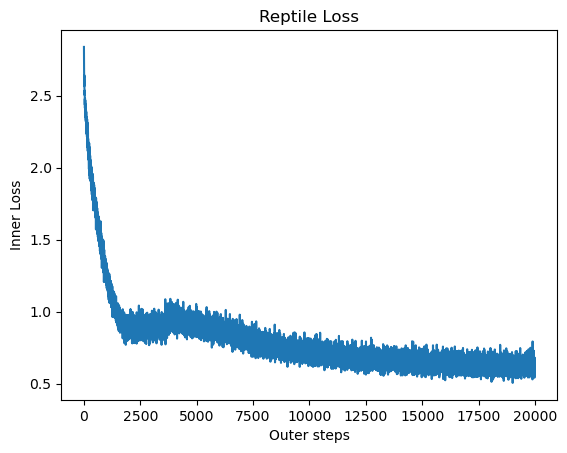

Array(0.62559366, dtype=float32)

In [20]:
import matplotlib.pyplot as plt
#plt.plot(losses[losses < 10])
plt.plot(losses)
plt.xlabel("Outer steps")
plt.ylabel("Inner Loss")
plt.title("Reptile Loss")
plt.show()
losses[-1000:].mean()

In [21]:
# EVALUATION PAREMETERS
n_char = 20  # number of characters
n_train = 1  # number of training images for each character
n_test = 15  # number of testing images for each character

(train_imgs, train_labels), (test_imgs, test_labels) = load_tasks((meta_test, meta_test_labels), n_char, n_train, n_test, TRAIN_KEY, do_augmentation=False)

In [22]:
model = eqx.tree_inference(model, value=True)
test_model, _, _ = inner_step_REPTILE(model, (train_imgs, train_labels), batch_loss, inner_optim, inner_opt_state, state)
test_model = eqx.Partial(test_model, state=state)
model = eqx.tree_inference(model, value=False)

17


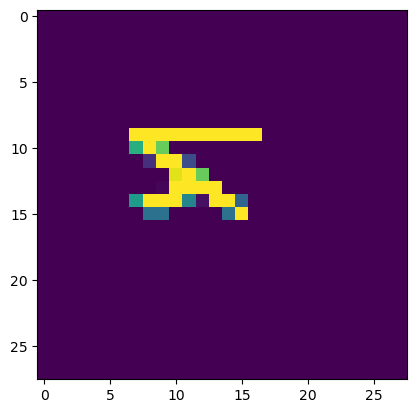

In [23]:
task, char, image =  0, 17, 0

test_img = test_imgs[n_test*char+image]
test_img_label = test_labels[n_test*char+image]

print(test_img_label)
plt.imshow(test_img[0])
plt.show()

In [24]:
pred = softmax(test_model(test_img)[0])
print(jnp.argmax(pred))
pred

2


Array([0.01419595, 0.00565016, 0.3313362 , 0.03089063, 0.02272715,
       0.03188896, 0.01051442, 0.01852193, 0.03994252, 0.06529775,
       0.00837797, 0.13891196, 0.01157614, 0.0136999 , 0.02137692,
       0.02854737, 0.0137069 , 0.15096478, 0.03740619, 0.0044662 ],      dtype=float32)

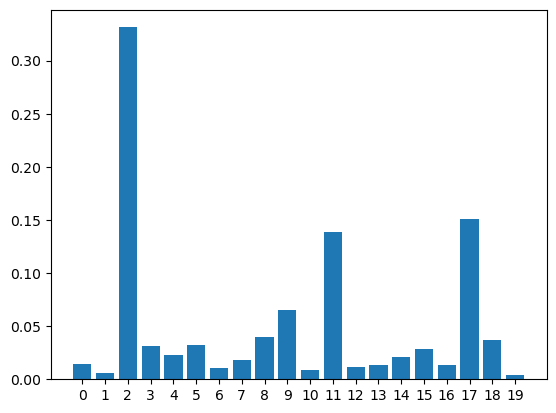

In [25]:
test_model(test_img)
plt.bar(range(n_char),softmax(test_model(test_img)[0])[jnp.unique(test_labels)])
plt.xticks(jnp.arange(n_char), jnp.unique(test_labels))
plt.show()

In [26]:
def accuracy(test_model, test_task, state):
    test_imgs, test_labels = test_task

    preds, state = eqx.filter_vmap(test_model, in_axes=(0,None),
                                  out_axes=(0,None),axis_name="chars")(test_imgs, state)
    argmaxs = eqx.filter_vmap(jnp.argmax)(preds)
    # return accuracy for this task
    return jnp.mean(argmaxs==test_labels), state


In [27]:
def evaluation(model, meta_set, n_char, n_train, n_test, batch_loss,
               inner_step, inner_optim, inner_opt_state, state, key):
    # meta_set = (meta_test, meta_test_labels)
    N = 100
    e = 420
    # evaluate on 420 characters instead of 423
    meta_test, meta_test_labels = meta_set
    meta_test_eval, meta_test_eval_labels = meta_test[:e], meta_test_labels[:e]
    ekey, tkey = split(key, 2)
    eval_keys = split(ekey, N)
    train_keys = split(tkey, N)
    data = []
    for i in range(N):
        # here we go through all the meta testing data
        perm = random.permutation(eval_keys[i], e)
        # permute the evaluation characters:
        perm_test, perm_test_labels = meta_test_eval[perm], meta_test_eval_labels[perm]
        # split up the 420 characters in sets of 20
        perm_test = rearrange(perm_test, "(t ch) i c h w -> t ch i c h w", ch=20)
        perm_test_labels = rearrange(perm_test_labels, "(t ch) -> t ch", ch=20)

        vmap_set = (perm_test, perm_test_labels)
        vmap_keys = split(train_keys[i],e//20)

        # load: 420/20 tasks
        train_tasks, test_tasks = eqx.filter_vmap(load_tasks, in_axes=(0,None,None,None,0,None))(vmap_set,n_char, n_train, n_test, vmap_keys, False)

        # train model one step for every task:
        test_models, _, _ = eqx.filter_vmap(inner_step,in_axes=(None,0,None,None,None,None),
                             out_axes=(eqx.if_array(0),None,0),axis_name="tasks"
                                   )(model, train_tasks, batch_loss,inner_optim, inner_opt_state, state)

        # take average of task accuracy:
        avg_task_acc = eqx.filter_vmap(accuracy, in_axes=(eqx.if_array(0),0,None),
                            out_axes=(eqx.if_array(0),None),axis_name="tasks"
                                      )(test_models, test_tasks,state)[0].mean()
        data.append(avg_task_acc)
    data = jnp.array(data)
    return data.mean(), data.std()


In [28]:
model = eqx.tree_inference(model, value=False)
evaluation(model, (meta_test, meta_test_labels), n_char, n_train,
           n_test, batch_loss, inner_step_REPTILE, inner_optim, inner_opt_state, state, TRAIN_KEY)

(Array(0.35848412, dtype=float32), Array(0.00971753, dtype=float32))